# Example 1, smooth function

The `zero_contour_finder` function will find points along the zero contour of a 2D function defined with Jax.  This example will walk though its basic usage and what each of the input parameters are.

## Imports

We begin with some basic imports for Jax, Matplotlib, and the zero contour functions.

```{note}
While it is necessary to use 64 bit precision to use the zero contour functions, it can be useful to help avoid floating point errors for very rapidly changing functions.
```

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from jax_zero_contour import (
    zero_contour_finder,
    value_and_grad_wrapper,
    stopping_conditions
)

For our first test we will create a function that will have two distinct closed contours.

In [3]:
def f(x, y):
    p = jnp.array([x, y])
    return 0.01 * ((p + 0.5)**4 - 30 * p**2 - 20 * p).sum(axis=0) + 2.0

For reference let's plot the function evaluated on an evenly spaced grid.  This is **not** used to find the contours, only for visualization purposes.  For the plot we will use a diverging symmetric log colorbar that is linear near the value of zero, this will help to visualize where the contour of interest are in the function.

In [8]:
n = 1024
x = jnp.linspace(-8, 8, n)
y = jnp.linspace(-8, 8, n)
X, Y = jnp.meshgrid(x, y)
z = f(X, Y)

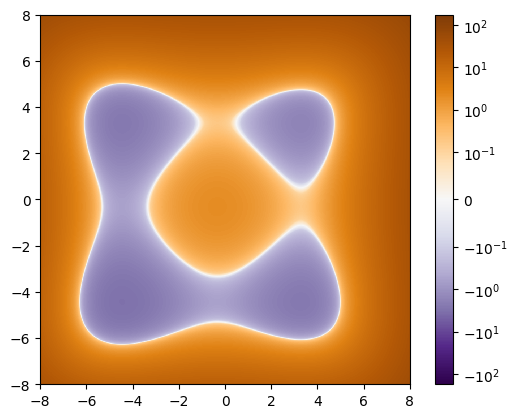

In [9]:
plt.imshow(
    z,
    extent=(x.min(), x.max(), y.min(), y.max()),
    norm=colors.SymLogNorm(linthresh=0.1, vmin=-175, vmax=175),
    cmap='PuOr_r',
    origin='lower',
    interpolation='nearest'
)
plt.colorbar()

## Finding the zero contours

There are two required inputs to `zero_contour_finder`:
- `value_and_grad_function`: A function of `x` and `y` that that returns the target function and its Jacobian, it is recommended that this function be `jit`ed.  This function **must** be wrapped in `jax.tree_util.Partial`.
- `init_guess`: Initial guess for a point near the zero contour.

To create the `value_and_grad_function` in the required format we will use the helper `value_and_grad_wrapper`.  This takes in a function of two variables and returns a `jit`ed and `jax.tree_util.Partial`ed function we can use as an input.

```{note}
`value_and_grad_wrapper` takes in the keyword `forward_mode_differentiation`, if set to true it will use `jacfwd` rather than `value_and_grad` to crete the required input.  This can be useful if your target function make use of `jax.numpy.where` and can't be reverse auto-differentiated.
```

In [10]:
v_and_g = value_and_grad_wrapper(f)

The final input is our initial guess of a point that is near the contour of interest.  Because our target function has two distinct zero contours we will run the `zero_contour_finder` function two times with different initial guesses.

Looking at the plot an input point of `(-2.0, 0.0)` should find the larger contour and the point `(4.0, 4.0)` should find the smaller one.

```{note}
Because the `value_and_grad_function` is `jit`ed before it is passed in, it will only be compiled during the first call.  When we call `zero_contour_finder` on the second input it will not re-compile.  This is why the function takes in a "value and grad function" rather than the base function only.
```

In [11]:
init_guess_1 = jnp.array([-2.0, 0.0])
path_1, values_1, stopping_conditions_1 = zero_contour_finder(
    v_and_g,
    init_guess_1
)
print(stopping_conditions_1)

[2]


In [12]:
init_guess_2 = jnp.array([4.0, 4.0])
path_2, values_2, stopping_conditions_2 = zero_contour_finder(
    v_and_g,
    init_guess_2
)
print(stopping_conditions_2)

[2]


Both run's returned a stopping condition of `2`, let's check what that means by looking at the `stopping_conditions` look up table:

In [13]:
stopping_conditions

{0: 'none', 1: 'end_point', 2: 'closed_loop'}

`2` indicates that the contours have both formed a "closed_loop" before stopping.  When this happens the resulting path is truncated at the point where the path closed.

Now we can plot the resulting contours along side the initial guesses and the value of each point along the contours.

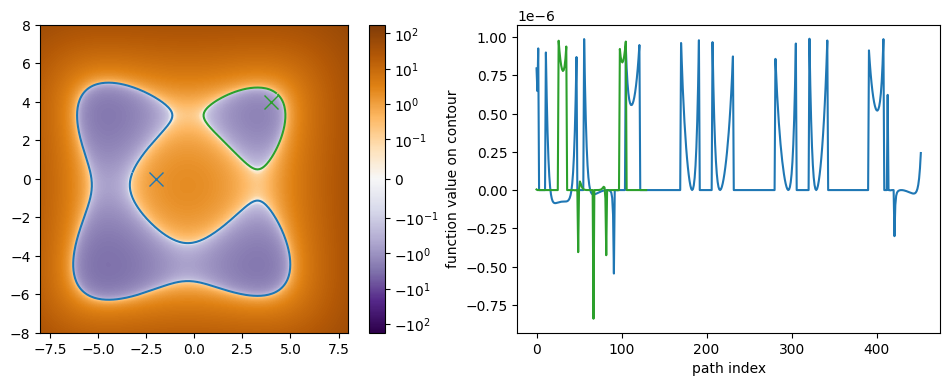

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(
    z,
    extent=(x.min(), x.max(), y.min(), y.max()),
    norm=colors.SymLogNorm(linthresh=0.1, vmin=-175, vmax=175),
    cmap='PuOr_r',
    origin='lower',
    interpolation='nearest'
)
plt.plot(*init_guess_1, 'x', ms=10, color='C0')
plt.plot(*path_1.T, color='C0')
plt.plot(*init_guess_2, 'x', ms=10, color='C2')
plt.plot(*path_2.T, color='C2')
plt.colorbar()

plt.subplot(122)
plt.xlabel('path index')
plt.ylabel('function value on contour')
plt.plot(values_1, color='C0')
plt.plot(values_2, color='C2');

In both cases we see that the value along the contours are within the default tolerance of {math}`10^{-6}`.  Before we move on to our next example, let's take a closer look at the generated path.  For clarity we will look at the smaller path, but this time plot the scatter points:

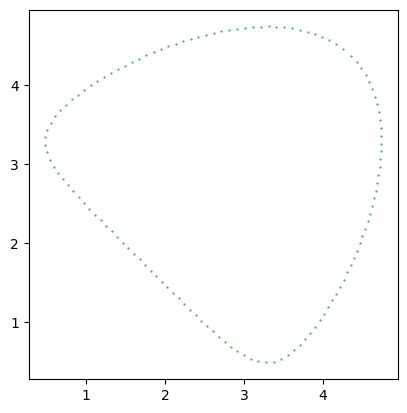

In [15]:
plt.plot(*path_2.T, '.', ms=1, color='C2')
plt.gca().set_aspect(1);

From this plot we can see that the generated point on the contour are very close to being evenly spaced.  The spacing of these points is controlled by the `delta` parameter that defaults to `0.1`.  Let's try adjusting this to get some points that are closer together.

In [16]:
path_2_close, values_2_close, stopping_conditions_2_close = zero_contour_finder(
    v_and_g,
    init_guess_2,
    delta=0.01
)
print(stopping_conditions_2_close)

[0 2]


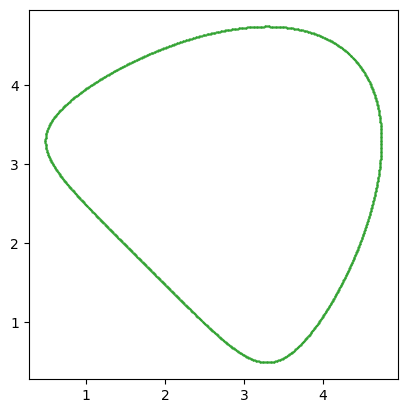

In [17]:
plt.plot(*path_2_close.T, '.', ms=1, color='C2')
plt.gca().set_aspect(1);

The points are so close together that on this plot it looks like a solid line.  If we try the same spacing for the longer contour we will see some different happen.

In [18]:
path_1_close, values_1_close, stopping_conditions_1_close = zero_contour_finder(
    v_and_g,
    init_guess_1,
    delta=0.01
)
print(stopping_conditions_1_close)

[0 0]


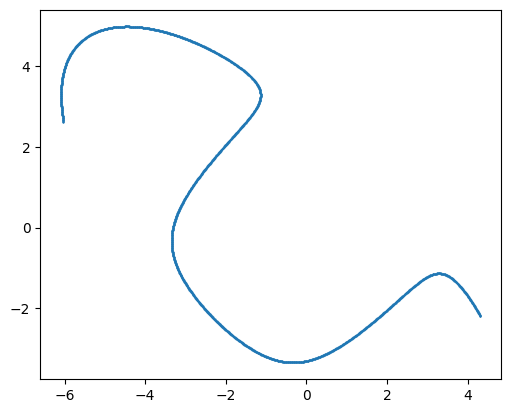

In [19]:
plt.plot(*path_1_close.T, '.', ms=1, color='C0')
plt.gca().set_aspect(1);

It looks like the contour did not close as the stopping conditions read `[0, 0]`!  This is because by default the `zero_contour_finder` function will trace the contour both clockwise and counterclockwise from the initial point up to 1000 steps in each direction before stopping.  The maximum number of points search in each direction is controlled by the `N` and `max_iter` parameters.

- `N`: Batch size for calculating new points along the contour, by default 100. After each batch the stopping conditions are checked: does the contour hit an end point or does the contour close.
- `max_iter`: The maximum number of batches to run in each direction from the initial point, by default 10.

```{note}
The two stopping conditions are for the path in each direction.  Typical examples are:
- [2]: The path close during the first (clockwise) search
- [0, 2]: The path did not close in the first search, but did close during the second (counterclockwise) search
- [0, 0]: The path did not close
- [1, 1]: The path hit endpoints in both directions
```

By default it will run at most 10 batches of size 100 in each direction, and after each batch check for a stopping condition.

Each batch is run as a `jax.lax.scan` of a fixed length `N` and these batches are placed in a Python `while` loop to check if a stopping condition has been triggered.  If `N` is large we don't need as many iterations to close the contour, but we might end up wasting computation time by "over shooting" the end point by a large amount.  If `N` is small we will be limited by the speed of the raw Python loop rather than the faster `scan`.

For this case we will try adjusting both values by a small amount.

In [20]:
path_1_close, values_1_close, stopping_conditions_1_close = zero_contour_finder(
    v_and_g,
    init_guess_1,
    delta=0.01,
    N=200,
    max_iter=15
)
print(stopping_conditions_1_close)

[0 2]


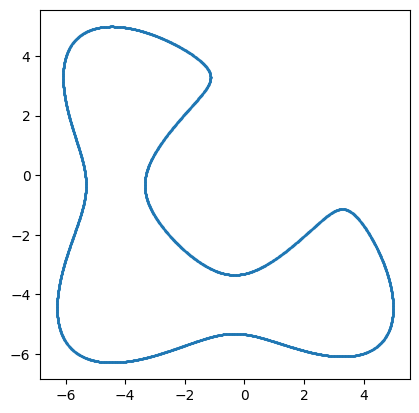

In [21]:
plt.plot(*path_1_close.T, '.', ms=1, color='C0')
plt.gca().set_aspect(1);

## Tolerance

The final optional keywords for the `zero_contour_finder` function are:
- `tol`: Newton's steps are used to bring each proposed point on the contour to be within this tolerance of zero, by default 1e-6.
- `max_newton`: The maximum number of Newton's steps to run, by default 5.

If you need to find the contour to a higher tolerance you can adjust the `tol` value to be smaller (down to your floating point precision).  By construction, each new proposed point on the contour should be close to zero, so very few Newton's steps should be needed to bring it back in line, but in the face of a function discontinuity or an place where the function's gradient is large, it can take more steps.  `max_newton` controls the allowed maximum number of steps that can be taken to avoid infinite loops.

As a test let's re-run the above contours with a smaller tolerance value.

```{note}
For 64 bit precision the smallest tolerance value that can be used is typically around {math}`10^{-15}`
```

In [22]:
path_1, values_1, stopping_conditions_1 = zero_contour_finder(
    v_and_g,
    init_guess_1,
    tol=1e-15
)
print(stopping_conditions_1)

path_2, values_2, stopping_conditions_2 = zero_contour_finder(
    v_and_g,
    init_guess_2,
    tol=1e-15
)
print(stopping_conditions_2)

[2]
[2]


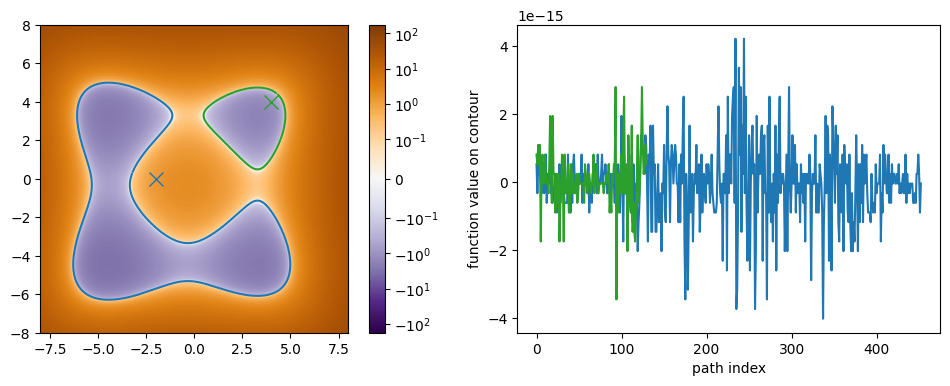

In [23]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(
    z,
    extent=(x.min(), x.max(), y.min(), y.max()),
    norm=colors.SymLogNorm(linthresh=0.1, vmin=-175, vmax=175),
    cmap='PuOr_r',
    origin='lower',
    interpolation='nearest'
)
plt.plot(*init_guess_1, 'x', ms=10, color='C0')
plt.plot(*path_1.T, color='C0')
plt.plot(*init_guess_2, 'x', ms=10, color='C2')
plt.plot(*path_2.T, color='C2')
plt.colorbar()

plt.subplot(122)
plt.xlabel('path index')
plt.ylabel('function value on contour')
plt.plot(values_1, color='C0')
plt.plot(values_2, color='C2');

We can now see the value of the function along the contour is far smaller than before.

## Stopping conditions

As pointed out in the previous section there are three different stopping conditions:

- `0`: none
- `1`: end point
- `2`: closed loop

### None

The maximum number of steps were taken before reaching either stopping condition below.

### End point

The zero value contour is not always closed, this can be caused by several thing such as a discontinuity in the function.  This stopping condition is triggered when the proposed next point in the path is more than `2 * delta` away from the previous point.

### Closed loop

When a contour loops back to it's starting point the contour is marked as being closed.  This stopping condition is triggered when the proposed next point is less than `1.1 * delta` away from the starting point of the path.